In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature
warnings.filterwarnings('ignore')
import time as timer
start_all = timer.time()

In [2]:
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"

In [3]:
#For selection and plotting
YR = 2010
time_bnds = (str(YR)+'-01-01',str(YR)+'-12-31')
lon_bnds, lat_bnds = (8,29), (5,-5)
lon_bnds_f, lat_bnds_f = (8, 29), (-5,5) 
p_bnds = (30000,100000)

**Read in ERA5 data on pressure levels (hourly timesteps in fortnightly files)**
- *fortnightly files currently run from 1994-2024*
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)


**Input file units:**
- plev - pa
- q - kg/kg
- u - m/s
- v - m/s

In [4]:
start = timer.time()
from functools import partial
def _preprocess_pres(x, lon_bnds, lat_bnds, p_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds),
                 plev=slice(*p_bnds),drop=True)
partial_func_pres = partial(_preprocess_pres, lon_bnds=lon_bnds, lat_bnds=lat_bnds, p_bnds=p_bnds)

#Reading in pressure level variables from ERA5
ds_era_pres = xr.open_mfdataset(dataf+"era5/pressure_levels/era5_pressure_level_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['r','t','w'],
                                preprocess=partial_func_pres,parallel=True).load()

ds_era_pres = ds_era_pres.rename({'plev':'level','q':'Shum','u':'Uwnd','v':'Vwnd'})
ds_era_pres['Shum'] = 1000.0*ds_era_pres['Shum']
ds_era_pres['level'] = ds_era_pres['level']/100.0  
ds_era_pres = ds_era_pres.sortby('level', ascending=False) 

end = timer.time()
length = end - start
print("ERA5 pressure level data read in took ", length, "seconds")

ERA5 pressure level data read in took  558.451434135437 seconds


**Read in ERA5 land data (hourly in monthly files)**
- selecting hour 23 (0-23) of Prec and Evap because of how ERA5 Land variables are accumulated (https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790 - https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations)
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- Prec, Evap, and Psfc are then resampled to MS monthly and also interpolated to coarser pressure level grid

**Input file units:**
- tp - m
- e - m (-)
- sp - pa

In [5]:
start = timer.time()
from functools import partial
def _preprocess_land(x, lon_bnds, lat_bnds):
    x = x.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds),drop=True)
    return x
partial_func_land = partial(_preprocess_land, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

#Reading in surface variables from ERA5 Land
ds_era_land = xr.open_mfdataset(dataf+"era5_land/era5_land_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number','pev','ssr','t2m'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_land = ds_era_land.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','tp':'Prec','e':'Evap','sp':'Psfc'})
ds_era_land = ds_era_land.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Prec = ds_era_land['Prec'].where(ds_era_land['time.hour']==23,drop=True)*1000.0
Evap_land = ds_era_land['Evap'].where(ds_era_land['time.hour']==23,drop=True)*-1000.0
Psfc_land = ds_era_land['Psfc']/100.0
ds_era_land.close()
end = timer.time()
length = end - start
print("ERA5 land data read in took ", length, "seconds")

ERA5 land data read in took  40.032541036605835 seconds


Read in ERA5 surface vars for merging - setting non land evaporation to zero. Merging surface pressure level and land surface pressure to output. 

In [6]:
start = timer.time()

#Reading in surface variables from ERA5 surface files
ds_era_psfc = xr.open_mfdataset(dataf+"era5/era5_surface/era5_surface_pressure_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_psfc = ds_era_psfc.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','sp':'Psfc'})
ds_era_psfc = ds_era_psfc.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Psfc_surface = ds_era_psfc['Psfc']/100.0
ds_era_psfc.close()

Evap = Evap_land.fillna(0.0)
Psfc = Psfc_land.combine_first(Psfc_surface)

length = end - start
print("ERA5 surface data read in took ", length, "seconds")

ERA5 surface data read in took  -0.015678882598876953 seconds


In [7]:
print("Psfc", Psfc.time)

print(ds_era_pres["Uwnd"].time)


#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds_era_pres["Shum"] * ds_era_pres["Uwnd"]
ds_era_pres['Fx'] = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, Psfc)
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds_era_pres["Shum"] * ds_era_pres["Vwnd"]
ds_era_pres['Fy'] = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, Psfc)
# Units: mb x m/s

print('********',ds_era_pres['Fy'])


Psfc <xarray.DataArray 'time' (time: 8760)> Size: 70kB
array(['2010-01-01T00:00:00.000000000', '2010-01-01T01:00:00.000000000',
       '2010-01-01T02:00:00.000000000', ..., '2010-12-31T21:00:00.000000000',
       '2010-12-31T22:00:00.000000000', '2010-12-31T23:00:00.000000000'],
      shape=(8760,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 70kB 2010-01-01 ... 2010-12-31T23:00:00
Attributes:
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time' (time: 8760)> Size: 70kB
array(['2010-01-01T00:00:00.000000000', '2010-01-01T01:00:00.000000000',
       '2010-01-01T02:00:00.000000000', ..., '2010-12-31T21:00:00.000000000',
       '2010-12-31T22:00:00.000000000', '2010-12-31T23:00:00.000000000'],
      shape=(8760,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 70kB 2010-01-01 ... 2010-12-31T23:00:00
Attributes:
    long_name:  time
******** <xarray.DataArray 'Fy' (time: 8760, lat: 41, lon: 85)> Size: 244MB
array([[

In [8]:
ds_era_pres = ds_era_pres.resample(time='MS').mean(dim='time')
Psfc = Psfc.resample(time='MS').mean(dim='time')
Prec = Prec.resample(time='MS').mean(dim='time')
Evap= Evap.resample(time='MS').mean(dim='time')

## Plotting the different evaporation arrays

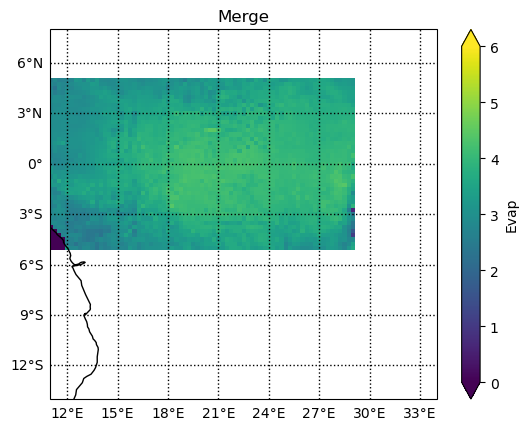

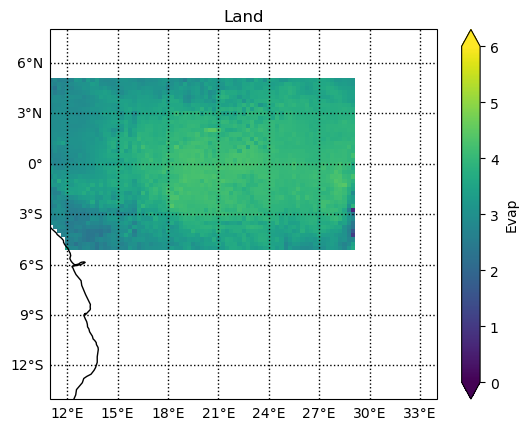

<Figure size 640x480 with 0 Axes>

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Evap.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       vmin=0,vmax=6,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Merge')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Evap_land.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       vmin=0,vmax=6,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Land')
#plt.savefig()
plt.show()
plt.clf()


## Plotting the different Psfc arrays

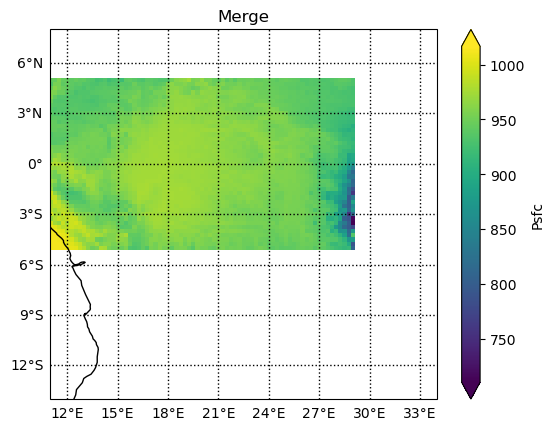

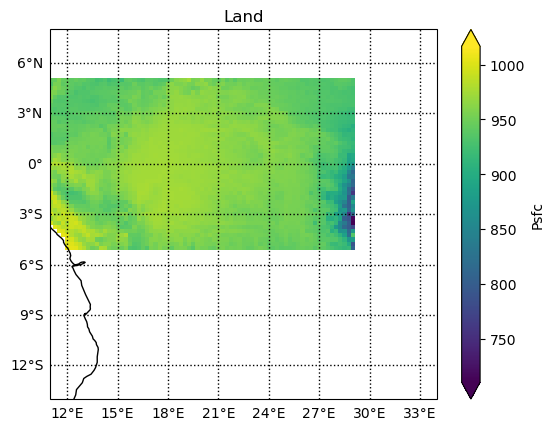

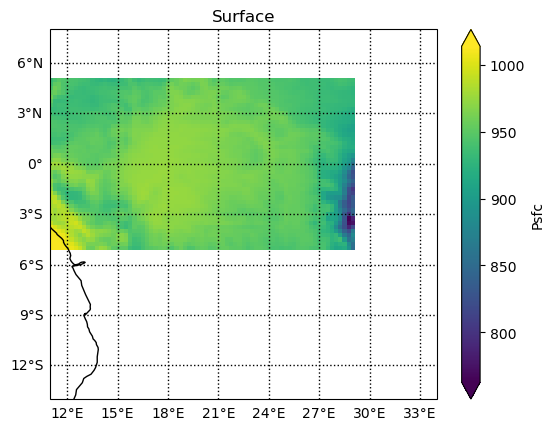

<Figure size 640x480 with 0 Axes>

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Merge')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc_land.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Land')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc_surface.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Surface')
#plt.savefig()
plt.show()
plt.clf()

**Merging all input datasets into one dataset for recyling code called ds**
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

In [11]:
start = timer.time()
ds = xr.merge([ds_era_pres,Prec,Evap,Psfc]) 
ds_era_pres.close()
ds = ds.sortby('lat', ascending=True)
ds = ds.sel(lat=slice(*lat_bnds_f),lon=slice(*lon_bnds_f))
ds = ds.transpose("lon", "lat", "level", "time",missing_dims='ignore')

ds.to_netcdf(datao+"/merge_int_ds/merge_erads_"+str(YR)+".nc", mode='w', format='NETCDF4', engine='netcdf4')
end = timer.time()
length = end - start
print("Merging and dataset output took ", length, "seconds")

Merging and dataset output took  5.428941011428833 seconds
